In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Expansion to Vector Es and Rs

In [5]:
torch.manual_seed(42)
# Converges to zero if i+1 is > i, but explodes if i+1 >> i. Converges to poor minima if i+1 < i (i as in, size[i])
sizes = [784, 256, 10]

def step(x, E, R, U):
    with torch.no_grad():
        E[0] = x - F.linear(R[0], U[0].weight, U[0].bias)
        E[1] = R[0] - F.linear(R[1], U[1].weight, U[1].bias)
    R[0] = R[0] + F.linear(E[0], U[0].weight.T)
    R[1] = R[1] + F.linear(E[1], U[1].weight.T)
    return E, R

In [6]:
# Initialise Dataset
x = torch.randn(sizes[0])
# x = torch.tensor([-0.2858, -1.0935,  1.1351,  0.7592])

U = [nn.Linear(sizes[i+1], sizes[i], bias=False) for i in range(len(sizes)-1) ]

e1s = []
e2s = []
    
# sum(u.weight.data.square().sum() for u in U)
U[0].weight.data.norm(), U[1].weight.data.norm()

(tensor(16.1726), tensor(9.1961))

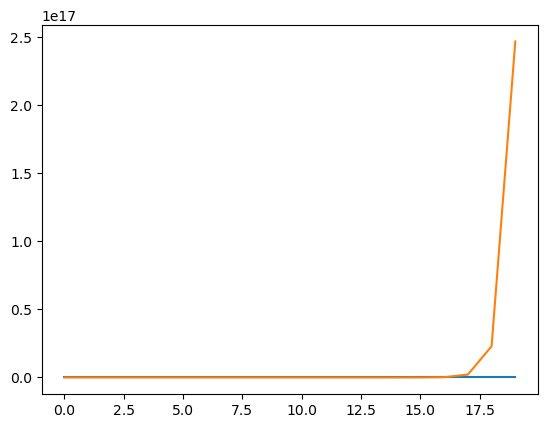

In [7]:
# Eval
batch_size = 1
# x = torch.randn(4) # Not learnt, high Es
# x = torch.tensor([-0.2858, -1.0935,  1.1351,  0.7592]) # learnt, therefore low Es
E = [torch.zeros((batch_size, sizes[i])) for i in range(len(sizes)-1)]
R = [torch.zeros((batch_size, sizes[i+1])) for i in range(len(sizes)-1)]

eval_e1s = []
eval_e2s = []
for _ in range(20):
    for i in range(len(sizes)-1):
        E[i] = E[i].detach()
        R[i] = R[i].detach()
    E, R = step(x, E, R, U)
    eval_e1s.append(E[0].abs().mean().item())
    eval_e2s.append(E[1].abs().mean().item())

plt.plot(eval_e1s, label='e1')
plt.plot(eval_e2s, label='e2')

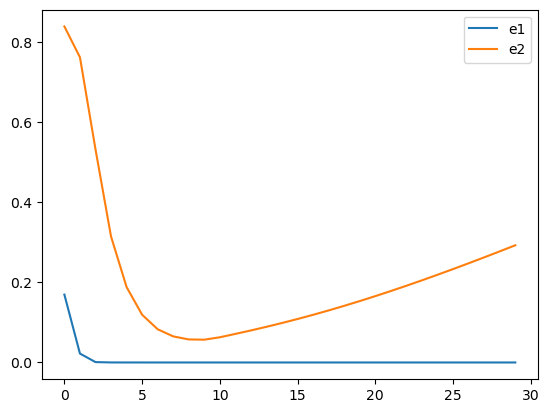

In [59]:

# Initialise Dataset
# x = torch.randn(sizes[0])
# x = torch.tensor([-0.2858, -1.0935,  1.1351,  0.7592])

U = [nn.Linear(sizes[i+1], sizes[i], bias=False) for i in range(len(sizes)-1) ]

e1s = []
e2s = []
    
# sum(u.weight.data.square().sum() for u in U)
U[0].weight.data.norm(), U[1].weight.data.norm()


lr = 0.1
epochs = 30
batch_size = 1
for _ in range(epochs):
    E = [torch.zeros((batch_size, sizes[i])) for i in range(len(sizes)-1)]
    R = [torch.zeros((batch_size, sizes[i+1])) for i in range(len(sizes)-1)]

    for _ in range(2):
        for i in range(len(sizes)-1):
            E[i] = E[i].detach()
            R[i] = R[i].detach()
        E, R = step(x, E, R, U)

    for u in U:
        u.zero_grad()
    reg = sum(u.weight.square().sum()*(i+4.5) for i, u in enumerate(U))
    loss = -0.5*sum(r.square().sum() for r in R) + 0.4*reg
    # print(loss)
    loss.backward()
    for u in U:
        u.weight.data -= lr * u.weight.grad

    # Full forward 
    E = [torch.zeros((batch_size, sizes[i])) for i in range(len(sizes)-1)]
    R = [torch.zeros((batch_size, sizes[i+1])) for i in range(len(sizes)-1)]

    for _ in range(20):
        for i in range(len(sizes)-1):
            E[i] = E[i].detach()
            R[i] = R[i].detach()
        E, R = step(x, E, R, U)
    # Tracking Errs
    e1s.append(E[0].abs().mean().item())
    e2s.append(E[1].abs().mean().item())

plt.plot(e1s, label="e1")
plt.plot(e2s, label="e2")
plt.legend()

In [49]:
for u in U:
    print(u.weight.abs().mean())

tensor(0.0852, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)


In [98]:
x = torch.tensor([[1.0, 2.0], [2.0, 3.0]])
print(x)
x = x.square()
print(x)

tensor([[1., 2.],
        [2., 3.]])
tensor([[1., 4.],
        [4., 9.]])


In [74]:
with torch.no_grad():
    U1.weight.grad = torch.zeros_like(U1.weight)
    U2.weight.grad = torch.zeros_like(U2.weight)
loss = 0.5*((r1**2).sum() + (r2**2).sum())
loss.sum().backward()
print(f'U1.weight.grad:\n{U1.weight.grad}')
print(f'U2.weight.grad:\n{U2.weight.grad}')

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [198]:
print(f'1:\n{torch.matmul(e1.unsqueeze(1), r1.unsqueeze(1).T).T}')
print(f'2:\n{torch.matmul(e2.unsqueeze(1), r2.unsqueeze(1).T).T}')

1:
tensor([[-0.6933,  0.4221],
        [-0.3558,  0.2166],
        [-0.3064,  0.1865],
        [ 0.1959, -0.1192]], grad_fn=<PermuteBackward0>)
2:
tensor([[-0.3013, -0.6518, -0.1750,  0.1821],
        [-0.2382, -0.5154, -0.1384,  0.1440],
        [-0.3859, -0.8350, -0.2242,  0.2333],
        [-0.1283, -0.2775, -0.0745,  0.0776],
        [-0.1763, -0.3815, -0.1024,  0.1066],
        [ 0.0057,  0.0124,  0.0033, -0.0035]], grad_fn=<PermuteBackward0>)


In [274]:
U = nn.Conv2d(1, 3, (3,3), bias=False)
optimiser = torch.optim.SGD(U.parameters(), lr=0.001)
Ut = nn.ConvTranspose2d(3, 1, (3,3))
with torch.no_grad():
    Ut.weight = U.weight
grad = torch.zeros_like(U.weight)
def step(x, e, r):
    with torch.no_grad():
        e = x - Ut(r)
    r = r + U(e)
    return e, r

In [275]:
x = torch.rand((1,1,4,4))
e = torch.zeros_like(x)
r = torch.zeros((1,3,2,2))

In [294]:
e = e.detach()
r = r.detach()
e, r = step(x, e, r)
print(e)
print(r)

tensor([[[[ 0.5686, -0.0906,  0.0353,  0.2347],
          [ 0.3378,  0.1243, -0.1070, -0.0324],
          [ 0.2056,  0.1212, -0.0081, -0.0222],
          [ 0.0375,  0.0403,  0.0899,  0.0199]]]])
tensor([[[[ 0.3041,  0.3235],
          [-0.1773, -0.0444]],

         [[-0.0907, -1.0017],
          [ 0.0183, -0.6439]],

         [[ 0.6487,  1.1892],
          [-0.4736, -0.6325]]]], grad_fn=<AddBackward0>)


In [295]:
optimiser.zero_grad()
loss = (0.5*(r**2)).sum()
print(loss)
loss.backward()
optimiser.step()

tensor(2.0582, grad_fn=<SumBackward0>)


In [296]:
U.weight.grad

tensor([[[[ 0.0782, -0.0334,  0.1071],
          [ 0.1011, -0.0180, -0.0406],
          [ 0.0933,  0.0231, -0.0265]]],


        [[[-0.0347,  0.0440, -0.2194],
          [-0.2294,  0.1033,  0.0563],
          [-0.1653, -0.0601,  0.0118]]],


        [[[ 0.0226, -0.0079,  0.3732],
          [ 0.1929, -0.0989, -0.0901],
          [ 0.2343, -0.0069, -0.0868]]]])